In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

import pywt
from astropy.stats import SigmaClip

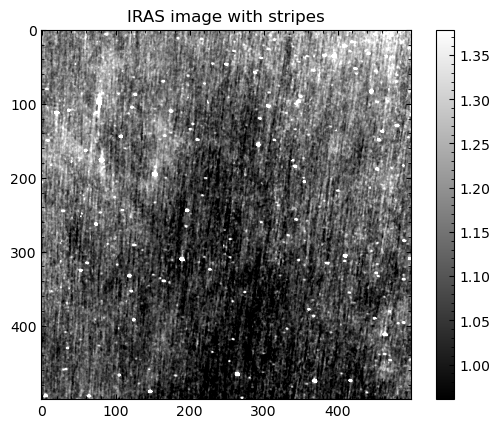

In [2]:
# load and display image
# https://irsa.ipac.caltech.edu/data/ISSA/
hdu = fits.open("image/iras_12um_field.fit")[0]

data = hdu.data[0]
data[~np.isfinite(data)] = 0
vmin, vmax = np.percentile(data, 5), np.percentile(data, 99.)
plt.imshow(data, vmin=vmin, vmax=vmax, cmap='gray')
plt.title("IRAS image with stripes")
plt.colorbar()

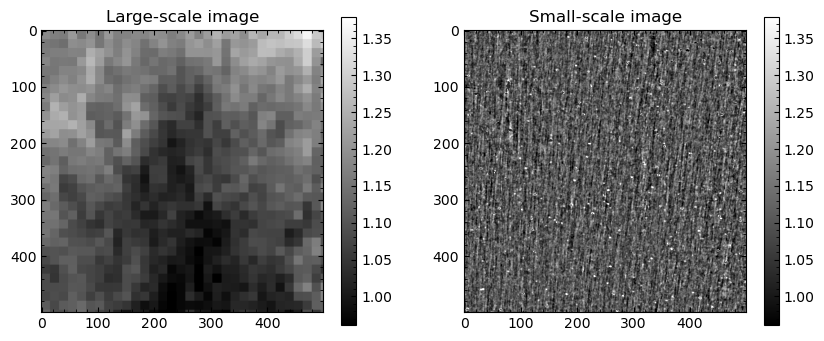

In [3]:
scale_idx = 5    # large/small scale division: 2^(5-1) = 16 pix
wavelet = 'db1'  # choose a wavelet

# clip point sources
sigma = SigmaClip(sigma=5, maxiters=5)
point_source = sigma(data).mask
data_clip = data.copy()
fill_value = np.mean(data)
data_clip[point_source] = fill_value # fill point sources with image average. better to use some interpolation methods.

# wavelet filtering
coeff_list = pywt.wavedec2(data_clip, wavelet, mode='symmetric', level=None, axes=(-2, -1))

# get large-scale image
coeff_large = coeff_list.copy()
for filter in range(scale_idx, len(coeff_large)):
    for arr in range(3):
        coeff_large[filter][arr][:,:] = 0

scale_large = pywt.waverec2(coeff_large, wavelet, mode='symmetric', axes=(-2, -1))

# get small-scale image
coeff_list = pywt.wavedec2(data_clip, wavelet, mode='symmetric', level=None, axes=(-2, -1))
coeff_small = coeff_list.copy()
for filter in range(1, scale_idx):
    for arr in range(3): 
        coeff_small[filter][arr][:,:] = 0
        
coeff_small[0][:,:] = np.mean(coeff_small[0])
        
scale_small = pywt.waverec2(coeff_small, wavelet, mode='symmetric', axes=(-2, -1))

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(scale_large, vmin=vmin, vmax=vmax, cmap='gray')
plt.title('Large-scale image')
plt.colorbar()
plt.subplot(122)
plt.imshow(scale_small, vmin=vmin, vmax=vmax, cmap='gray')
plt.title('Small-scale image')
plt.colorbar()

In [4]:
# FFT of the small_scale image
from numpy.fft import fft2, ifft2, fftshift
small_fft = fftshift(fft2(scale_small))

# replace the "spikes" by the averaged azimuthal magnitude.
c = len(small_fft) // 2

## polar coordinate
indy, indx = np.indices(data.shape)
r = np.sqrt((indx - c + 0.5)**2 + (indy - c + 0.5)**2)
phi = np.floor( np.arctan2(- indy + c - 0.5, indx - c + 0.5) * 180 / np.pi )
phi += 180

## mean value in each direcion
dir_mean_val = [np.median(np.abs(small_fft)[(phi == i) & (r < c)]) for i in range(360)]

## find the outliers
med, std  = np.median(dir_mean_val), np.std(dir_mean_val)
thresh = med + std * 1
theta_clip = np.where(dir_mean_val > thresh)[0]
theta_clip_map = np.full(small_fft.shape, False)
for theta in theta_clip:
    theta_clip_map[phi == theta] = True


small_fft_clip = small_fft.copy()
small_fft_abs = np.abs(small_fft)

### profile of the fft image
prof_r = np.arange(int(c * 1.414))
prof_val = np.full(prof_r.shape, 0.)

for rr in prof_r:
    prof_val[rr] = np.mean(small_fft_abs[(np.abs(r - rr) < 1) & (~theta_clip_map)])
    
from scipy.interpolate import interp1d
profile = interp1d(prof_r, prof_val)

## fill the clipped direction with azimuthal average value
for theta in theta_clip:
    ii, jj = np.where(phi == theta)
    for i, j in zip(ii, jj):
        dist = np.sqrt((i - c + 0.5)**2 + (j - c + 0.5)**2)
        if dist == 0: continue
        shrink_factor = small_fft_abs[i][j] / profile(dist)
        small_fft_clip[i][j] /= shrink_factor

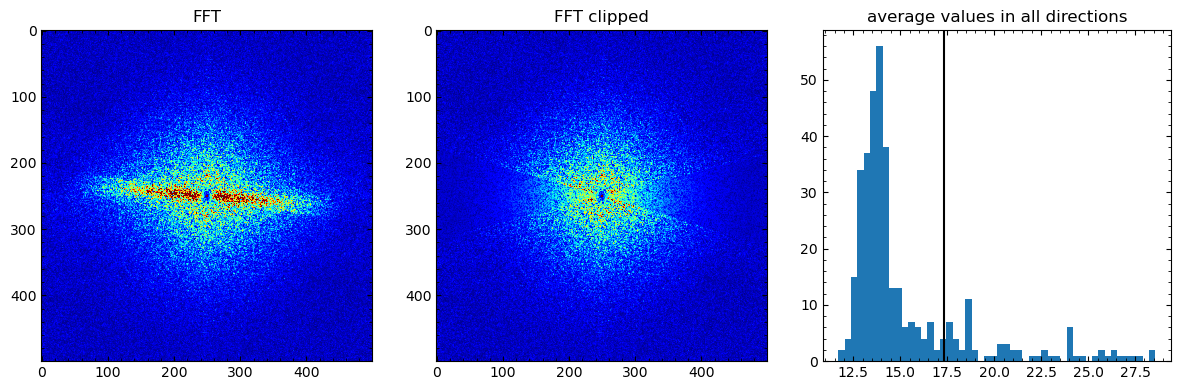

In [5]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title("FFT")
plt.imshow(np.abs(small_fft.real), vmin=0, vmax=100, cmap='jet')
plt.subplot(132)
plt.title("FFT clipped")
plt.imshow(np.abs(small_fft_clip.real), vmin=0, vmax=100, cmap='jet')
plt.subplot(133)
plt.hist(dir_mean_val, bins=50);
plt.axvline(thresh, c='k')
plt.title("average values in all directions")
plt.tight_layout()

In [6]:
# inverse fft
scale_small_clip = ifft2(fftshift(small_fft_clip)).real

# reconstruct destripped image
coeff_small_clip = pywt.wavedec2(scale_small_clip, wavelet, mode='symmetric', level=None, axes=(-2, -1))

coeff_rec = []
for i in range(len(coeff_small_clip)):
    if i < scale_idx:
        coeff_rec.append(coeff_large[i])
    else:
        coeff_rec.append(coeff_small_clip[i])

img_rec = pywt.waverec2(coeff_rec, wavelet, mode='symmetric', axes=(-2, -1))

# add point sources back
img_rec[point_source] = data[point_source] + img_rec[point_source] - fill_value

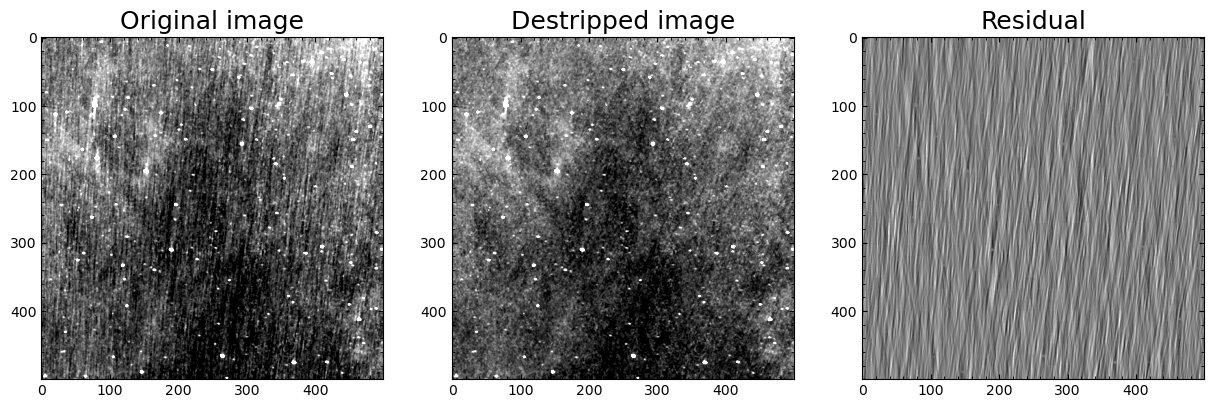

In [7]:
# display the results!
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(data, vmin=vmin, vmax=vmax, cmap='gray')
plt.title("Original image", fontsize=18)
#plt.colorbar()
plt.subplot(132)
plt.imshow(img_rec, vmin=vmin, vmax=vmax, cmap='gray')
plt.title("Destripped image", fontsize=18)
#plt.colorbar()
plt.subplot(133)
plt.imshow((img_rec - data) / data, vmin=-.1, vmax=.1, cmap='gray')
plt.title("Residual", fontsize=18)
#plt.colorbar()

plt.savefig('demo.png', bbox_inches='tight', pad_inches=0.1, dpi=150)